In [4]:
'''
他クラスロジスティック回帰を使った画像分類

'''

'\n他クラスロジスティック回帰を使った画像分類\n\n'

In [2]:
!pip uninstall torch torchvision -y
!pip install torch==1.13.0 torchvision==0.14.0 -f https://download.pytorch.org/whl/cu121/torch_stable.html

Found existing installation: torch 1.13.0
Uninstalling torch-1.13.0:
  Successfully uninstalled torch-1.13.0
Found existing installation: torchvision 0.14.0
Uninstalling torchvision-0.14.0:
  Successfully uninstalled torchvision-0.14.0
Looking in links: https://download.pytorch.org/whl/cu121/torch_stable.html
  Using cached torch-1.13.0-cp310-cp310-manylinux1_x86_64.whl.metadata (23 kB)
  Using cached torchvision-0.14.0-cp310-cp310-manylinux1_x86_64.whl.metadata (11 kB)
Using cached torch-1.13.0-cp310-cp310-manylinux1_x86_64.whl (890.1 MB)
Using cached torchvision-0.14.0-cp310-cp310-manylinux1_x86_64.whl (24.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.1+cu121 requires torch==2.3.1, but you have torch 1.13.0 which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 1.13.0 which is incompatible.


In [5]:
import random
from collections import deque
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# PyTorch関係のモジュール
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

In [6]:
dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True)

100%|██████████| 170498071/170498071 [00:01<00:00, 102831093.46it/s]


Extracting data/cifar-10-python.tar.gz to data


frog


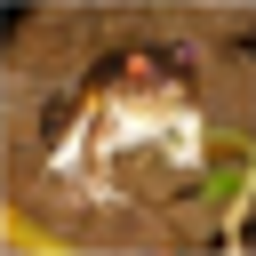

truck


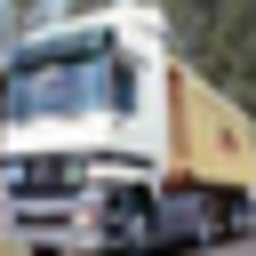

deer


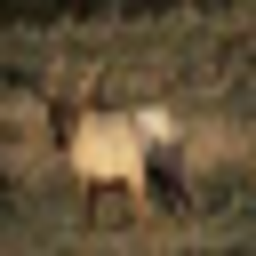

automobile


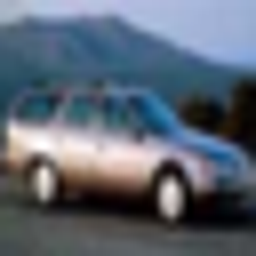

bird


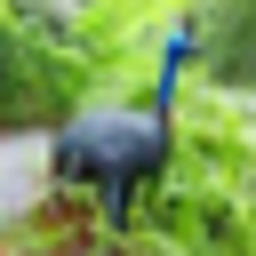

horse


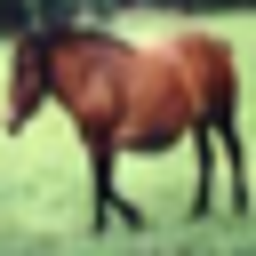

ship


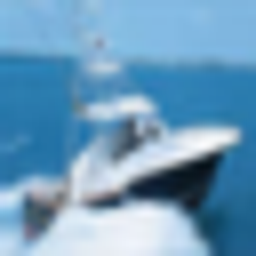

cat


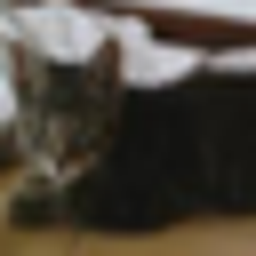

dog


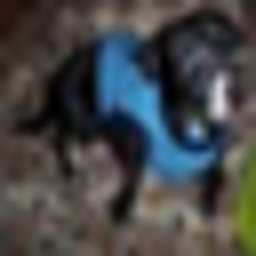

airplane


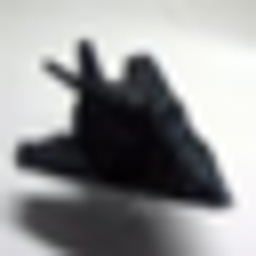

In [7]:
displayed_classes = set()
i = 0
while i < len(dataset) and len(displayed_classes) < len(dataset.classes):
    img, label = dataset[i]
    if label not in displayed_classes:
        print("{}".format(dataset.classes[label]))
        img = img.resize((256, 256))
        display(img)
        displayed_classes.add(label)
    i += 1

In [8]:
len(dataset)

50000

In [9]:
x = []
y = []
num_samples = 200
for i in range(num_samples):
    img, label = dataset[i]
    img_flatten = np.asarray(img).flatten()
    x.append(img_flatten)
    y.append(label)
x = np.stack(x)
y = np.array(y)

In [10]:
t_sne = TSNE(n_components=2, random_state=0)
x_reduced = t_sne.fit_transform(x)

In [11]:
'''
データセットの構築
ホールドアウト法：データセットの分割、学習セットと検証セットによる学習と評価を繰り返して最適なハイパーパラメータを毛挺してテストセットを使ってモデルの性能評価をする
'''

'\nデータセットの構築\nホールドアウト法：データセットの分割、学習セットと検証セットによる学習と評価を繰り返して最適なハイパーパラメータを毛挺してテストセットを使ってモデルの性能評価をする\n'

In [12]:
# データセットを２つに分割するためのインデッkすす集合を生成
def generate_subset(
    dataset: Dataset,
    ratio: float,
    random_seed: int=0
):
    size=int(len(dataset)*ratio)
    indices=list(range(len(dataset)))

    random.seed(random_seed)
    random.shuffle(indices)

    indices1, indices2 = indices[:size], indices[size:]

    return indices1, indices2

In [13]:
# CIFAR10はテストセットは分割D切るように実装されていてtrain引数で切り替えられる

In [14]:
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='data', train=False, download=True)

val_ratio = 0.2
val_set, train_set = generate_subset(train_dataset, val_ratio)

print("train: {}".format(len(train_set)))
print("validate: {}".format(len(val_set)))
print("test: {}".format(len(test_dataset)))


Files already downloaded and verified
Files already downloaded and verified
train: 40000
validate: 10000
test: 10000


In [15]:
# データの整形
def transform(
    img: Image.Image,
    channel_mean: np.ndarray = None,
    channel_std: np.ndarray = None
):
    img = np.asarray(img, dtype='float32')
    x = img.flatten()

    if channel_mean is not None and channel_std is not None: # 正規化
        x = (x - channel_mean)/channel_std

    return x

In [16]:
def get_dataset_statistics(dataset: Dataset):
    data = []
    for i in range(len(dataset)):
        img_flat = dataset[i][0] # 0番目はimg, 1番目にはラベル
        data.append(img_flat)

    data = np.stack(data)
    channel_mean = np.mean(data, axis=0) # axis=0は列方向
    channel_std = np.std(data, axis=0)

    return channel_mean, channel_std

In [17]:
# ラベルの整形
def label_transform(
    label: int,
    num_classes: int = 10
):
    y = np.identity(num_classes)[label] # ラベルに対応する要素の値が１でその他が0のnum_classesの大きさのベクトル(one-hot)

    return y

In [18]:
# データ整形のテスト
dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
channel_mean, channel_std = get_dataset_statistics(dataset)

img_transform = lambda x: transform(x, channel_mean, channel_std)
dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=img_transform, target_transform=label_transform)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
img, label = dataset[0]
print("画像: {}".format(img))
print("ラベル: {}".format(label))

画像: [-0.97683984 -1.015768   -0.8645673  ... -0.05604946 -0.54032654
 -0.64139867]
ラベル: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [20]:
class MultiClassLogisticRegression:
    def __init__(
        self,
        dim_input: int,
        num_classes: int = 10
    ):
        self.weight = np.random.normal(scale=0.01, size=(dim_input, num_classes)) # 重みは平均0、標準偏差0.01の正規分布
        self.bias = np.zeros(num_classes)

    def _softmax(self, x: np.ndarray):
        return np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)

    def predict(self, x: np.ndarray):
        l = np.matmul(x, self.weight) + self.bias
        y = self._softmax(l)
        return y

In [21]:
model = MultiClassLogisticRegression(32*32*3)

x = np.random.normal(size=(1, 32*32*3)) # 無作為な入力データで予測確率を確認
y = model.predict(x)
print("確率: {}".format(y))

確率: [[0.16859506 0.04414103 0.13730251 0.11908956 0.04031178 0.0816255
  0.21549297 0.0882928  0.05876559 0.0463832 ]]


In [22]:
'''
・他クラスロジスティック回帰（多クラス分類）のパラメータの更新
モデルは重みとバイアスを含む
目的関数を設定して勾配降下方を使う

バッチ購買効果法　学習セットのすべてのサンプル
確率的購買降下ほう　無作為に１サンプル
ミニバッチ　Bこのサンプル
バッチ購買降下法；パラメータ更新の意計算量が多い
確率k的購買降下ほう：勾配のばらつきが大きく最適か今時間がかかる
ミニバッチ：バッチサイズを変えることで１回の更新あたりの計算量を調整、不空数サンプルでこう場合を計算して勾配の方向を安定


勾配降下法はよりよいパラメータに遷移させるための考え方、（更新）
誤差逆伝搬法はニューラルネットワークの大量のパラメータに対してどう効率よく計算していくかの手法（学習）

・他クラスロジスティック回帰のパラメータの学習
目的関数に黄砂エントロピー誤差を使う（真の確率分布と予測された確率分布が一致するときに最小）
２乗わ誤差よりも使われる、理由は、交差エントロピー誤差は確率的勾配降下法との相性が良いから
/分類問題を扱う際には交差エントロピーが頻繁に使われます。教師データと学習結果が大きく乖離している（損失関数の値が大きい）時、交差エントロピーを使った方が学習スピードが早い！！（１学習あたりの損失関数の減少幅が大きい）
/シグモイド関数との相性がよい。

勾配の計算には合成関数の連鎖律（誤差逆伝播法の基本原理である連鎖率）
'''

'\n・他クラスロジスティック回帰（多クラス分類）のパラメータの更新\nモデルは重みとバイアスを含む\n目的関数を設定して勾配降下方を使う\n\nバッチ購買効果法\u3000学習セットのすべてのサンプル\n確率的購買降下ほう\u3000無作為に１サンプル\nミニバッチ\u3000Bこのサンプル\nバッチ購買降下法；パラメータ更新の意計算量が多い\n確率k的購買降下ほう：勾配のばらつきが大きく最適か今時間がかかる\nミニバッチ：バッチサイズを変えることで１回の更新あたりの計算量を調整、不空数サンプルでこう場合を計算して勾配の方向を安定\n\n\n勾配降下法はよりよいパラメータに遷移させるための考え方、（更新）\n誤差逆伝搬法はニューラルネットワークの大量のパラメータに対してどう効率よく計算していくかの手法（学習）\n\n・他クラスロジスティック回帰のパラメータの学習\n目的関数に黄砂エントロピー誤差を使う（真の確率分布と予測された確率分布が一致するときに最小）\n２乗わ誤差よりも使われる、理由は、交差エントロピー誤差は確率的勾配降下法との相性が良いから\n/分類問題を扱う際には交差エントロピーが頻繁に使われます。教師データと学習結果が大きく乖離している（損失関数の値が大きい）時、交差エントロピーを使った方が学習スピードが早い！！（１学習あたりの損失関数の減少幅が大きい）\n/シグモイド関数との相性がよい。\n\n勾配の計算には合成関数の連鎖律（誤差逆伝播法の基本原理である連鎖率）\n'

In [31]:
class MultiClassLogisticRegression:
    def __init__(
        self,
        dim_input: int,
        num_classes: int = 10
    ):
        self.weight = np.random.normal(scale=0.01, size=(dim_input, num_classes)) # 重みは平均0、標準偏差0.01の正規分布
        self.bias = np.zeros(num_classes)

    def _softmax(self, x: np.ndarray):
        return np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)

    def predict(self, x: np.ndarray):
        l = np.matmul(x, self.weight) + self.bias
        y = self._softmax(l)
        return y

    # パラメータ更新（目的関数は交差エントロピー誤差）
    def update_parameters(
        self,
        x: np.ndarray,
        y: np.ndarray, # one-hot vector
        y_pred: np.ndarray,
        lr: float = 0.001
    ):
        # 連鎖律によって勾配を数値的に求める必要がなくなっている
        diffs = y_pred - y
        self.weight -= lr*np.mean(x[:,:,np.newaxis]*diffs[:,np.newaxis], axis=0)
        self.bias -= lr*np.mean(diffs, axis=0)

    '''
    モデルを複製して返す関数
    '''
    def copy(self):
        model_copy = self.__class__(*self.weight.shape)
        model_copy.weight = self.weight.copy()
        model_copy.bias = self.bias.copy()

        return model_copy

In [24]:
'''
モデルの学習
ミニバッチ勾配降下法でパラメータを更新
エポック数：学習セット全サンプルを何回抽出したか
イテレーション数（パラメータの更新回数）：ミニバッチを何回抽出したか
チューニング：検証セットを使って目的関数が上昇を始める（誤差が大きくなる）前に止める
早期停止：目的関数の値が上昇を始める直前のエポック数を最適なエポック数とする
'''

'\nモデルの学習\nミニバッチ勾配降下法でパラメータを更新\nエポック数：学習セット全サンプルを何回抽出したか\nイテレーション数（パラメータの更新回数）：ミニバッチを何回抽出したか\nチューニング：検証セットを使って目的関数が上昇を始める（誤差が大きくなる）前に止める\n早期停止：目的関数の値が上昇を始める直前のエポック数を最適なエポック数とする\n'

In [24]:
'''
# データローダの生成
train_sampler = SubsetRandomSampler(train_dataset) # インデックス集合から無作為にインデックスを抽出
train_loader = DataLoader(train_dataset, batch_size=config.batch_size)
'''

In [33]:
class Config:
    '''
    ハイパーパラメータとオプションの設定
    '''
    def __init__(self):
        self.val_ratio = 0.2          # 検証に使う学習セット内のデータの割合
        self.num_epochs = 30          # 学習エポック数
        self.lrs = [1e-2, 1e-3, 1e-4] # 検証する学習率
        self.moving_avg = 20          # 移動平均で計算する損失と正確度の値の数
        self.batch_size = 32          # バッチサイズ
        self.num_workers = 2          # データローダーに使うCPUプロセスの数

def train_eval():
    config = Config()

    # 入力データ正規化のために学習セットのデータを使って
    # 各次元の平均と標準偏差を計算
    dataset = torchvision.datasets.CIFAR10(
        root='data', train=True, download=True, transform=transform)
    channel_mean, channel_std = get_dataset_statistics(dataset)

    # 正規化を含めた画像整形関数の用意
    img_transform = lambda x: transform(x, channel_mean, channel_std)

    # 学習、評価セットの用意
    train_dataset = torchvision.datasets.CIFAR10(
        root='data', train=True, download=True,
        transform=img_transform, target_transform=label_transform)
    test_dataset = torchvision.datasets.CIFAR10(
        root='data', train=False, download=True,
        transform=img_transform, target_transform=label_transform)

    # 学習・検証セットへ分割するためのインデックス集合の生成
    val_set, train_set = generate_subset(
        train_dataset, config.val_ratio)

    print(f'学習セットのサンプル数　: {len(train_set)}')
    print(f'検証セットのサンプル数　: {len(val_set)}')
    print(f'テストセットのサンプル数: {len(test_dataset)}')

    # インデックス集合から無作為にインデックスをサンプルするサンプラー
    train_sampler = SubsetRandomSampler(train_set)

    # DataLoaderを生成
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=train_sampler)
    val_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=val_set)
    test_loader = DataLoader(
        test_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers)

    # 検証セットの結果による最良モデルの保存用変数
    val_loss_best = float('inf')
    model_best = None
    for lr in config.lrs:
        print(f'学習率: {lr}')

        # 多クラスロジスティック回帰モデルの生成
        model = MultiClassLogisticRegression(
            32 * 32 * 3, len(train_dataset.classes))

        for epoch in range(config.num_epochs):
            with tqdm(train_loader) as pbar:
                pbar.set_description(f'[エポック {epoch + 1}]')

                '''
                # 移動平均計算用
                losses = deque()
                accs = deque()
                '''
                for x, y in pbar:
                    # サンプルしたデータはPyTorchのTensorに
                    # 変換されているのためNumPyデータに戻す
                    x = x.numpy()
                    y = y.numpy()

                    y_pred = model.predict(x)

                    '''
                    # 学習データに対する目的関数と正確度を計算
                    loss = np.mean(
                        np.sum(-y * np.log(y_pred), axis=1))
                    # Maxのインデックスは数字表現のクラスラベル
                    accuracy = np.mean(np.argmax(y_pred, axis=1) == \
                                       np.argmax(y, axis=1))

                    # 移動平均を計算して表示
                    losses.append(loss)
                    accs.append(accuracy)
                    if len(losses) > config.moving_avg:
                        losses.popleft()
                        accs.popleft()
                    pbar.set_postfix({'loss': np.mean(losses),
                                      'accuracy': np.mean(accs)})
                    '''

                    # パラメータを更新
                    model.update_parameters(x, y, y_pred, lr=lr)

            # 検証セットを使って精度評価
            val_loss, val_accuracy = evaluate(val_loader, model)
            print(f'検証　: loss = {val_loss:.3f}, '
                  f'accuracy = {val_accuracy:.3f}')

            # より良い検証結果が得られた場合、モデルを記録
            if val_loss < val_loss_best:
                val_loss_best = val_loss
                model_best = model.copy()

    # テスト
    test_loss, test_accuracy = evaluate(test_loader, model_best)
    print(f'テスト: loss = {test_loss:.3f}, '
          f'accuracy = {test_accuracy:.3f}')

def evaluate(data_loader: DataLoader,
             model: MultiClassLogisticRegression):
    losses = []
    preds = []
    for x, y in data_loader:
        x = x.numpy()
        y = y.numpy()

        y_pred = model.predict(x)

        losses.append(np.sum(-y * np.log(y_pred), axis=1))

        preds.append(np.argmax(y_pred, axis=1) == \
                     np.argmax(y, axis=1))

    loss = np.mean(np.concatenate(losses))
    accuracy = np.mean(np.concatenate(preds))

    return loss, accuracy


In [34]:
train_eval()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
学習セットのサンプル数　: 40000
検証セットのサンプル数　: 10000
テストセットのサンプル数: 10000
学習率: 0.01


[エポック 1]: 100%|██████████| 1250/1250 [00:28<00:00, 44.24it/s]


検証　: loss = 1.918, accuracy = 0.369


[エポック 2]: 100%|██████████| 1250/1250 [00:24<00:00, 50.52it/s]


検証　: loss = 1.968, accuracy = 0.354


[エポック 3]: 100%|██████████| 1250/1250 [00:28<00:00, 44.17it/s]


検証　: loss = 2.003, accuracy = 0.349


[エポック 4]: 100%|██████████| 1250/1250 [00:27<00:00, 46.23it/s]


検証　: loss = 1.943, accuracy = 0.353


[エポック 5]: 100%|██████████| 1250/1250 [00:23<00:00, 52.18it/s]


検証　: loss = 1.925, accuracy = 0.353


[エポック 6]: 100%|██████████| 1250/1250 [00:24<00:00, 50.45it/s]


検証　: loss = 1.893, accuracy = 0.365


[エポック 7]: 100%|██████████| 1250/1250 [00:29<00:00, 42.72it/s]


検証　: loss = 1.893, accuracy = 0.380


[エポック 8]: 100%|██████████| 1250/1250 [00:26<00:00, 47.22it/s]


検証　: loss = 1.932, accuracy = 0.364


[エポック 9]: 100%|██████████| 1250/1250 [00:26<00:00, 48.06it/s]


検証　: loss = 1.979, accuracy = 0.346


[エポック 10]: 100%|██████████| 1250/1250 [00:27<00:00, 45.69it/s]


検証　: loss = 1.947, accuracy = 0.368


[エポック 11]: 100%|██████████| 1250/1250 [00:25<00:00, 48.16it/s]


検証　: loss = 1.887, accuracy = 0.375


[エポック 12]: 100%|██████████| 1250/1250 [00:26<00:00, 46.97it/s]


検証　: loss = 1.948, accuracy = 0.353


[エポック 13]: 100%|██████████| 1250/1250 [00:25<00:00, 48.84it/s]


検証　: loss = 1.956, accuracy = 0.362


[エポック 14]: 100%|██████████| 1250/1250 [00:29<00:00, 43.05it/s]


検証　: loss = 1.971, accuracy = 0.353


[エポック 15]: 100%|██████████| 1250/1250 [00:27<00:00, 46.06it/s]


検証　: loss = 1.964, accuracy = 0.362


[エポック 16]: 100%|██████████| 1250/1250 [00:24<00:00, 50.39it/s]


検証　: loss = 1.937, accuracy = 0.351


[エポック 17]: 100%|██████████| 1250/1250 [00:27<00:00, 45.36it/s]


検証　: loss = 1.956, accuracy = 0.348


[エポック 18]: 100%|██████████| 1250/1250 [00:28<00:00, 43.30it/s]


検証　: loss = 1.935, accuracy = 0.358


[エポック 19]: 100%|██████████| 1250/1250 [00:23<00:00, 52.25it/s]


検証　: loss = 1.992, accuracy = 0.355


[エポック 20]: 100%|██████████| 1250/1250 [00:23<00:00, 53.46it/s]


検証　: loss = 1.928, accuracy = 0.370


[エポック 21]: 100%|██████████| 1250/1250 [00:28<00:00, 43.86it/s]


検証　: loss = 1.959, accuracy = 0.349


[エポック 22]: 100%|██████████| 1250/1250 [00:25<00:00, 49.70it/s]


検証　: loss = 2.091, accuracy = 0.325


[エポック 23]: 100%|██████████| 1250/1250 [00:26<00:00, 47.85it/s]


検証　: loss = 1.944, accuracy = 0.368


[エポック 24]: 100%|██████████| 1250/1250 [00:28<00:00, 44.16it/s]


検証　: loss = 1.994, accuracy = 0.354


[エポック 25]: 100%|██████████| 1250/1250 [00:29<00:00, 42.68it/s]


検証　: loss = 1.976, accuracy = 0.351


[エポック 26]: 100%|██████████| 1250/1250 [00:25<00:00, 49.38it/s]


検証　: loss = 1.965, accuracy = 0.347


[エポック 27]: 100%|██████████| 1250/1250 [00:25<00:00, 48.50it/s]


検証　: loss = 1.993, accuracy = 0.354


[エポック 28]: 100%|██████████| 1250/1250 [00:28<00:00, 43.58it/s]


検証　: loss = 1.981, accuracy = 0.366


[エポック 29]: 100%|██████████| 1250/1250 [00:28<00:00, 43.36it/s]


検証　: loss = 2.065, accuracy = 0.341


[エポック 30]: 100%|██████████| 1250/1250 [00:24<00:00, 50.84it/s]


検証　: loss = 2.101, accuracy = 0.333
学習率: 0.001


[エポック 1]: 100%|██████████| 1250/1250 [00:24<00:00, 50.92it/s]


検証　: loss = 1.798, accuracy = 0.384


[エポック 2]: 100%|██████████| 1250/1250 [00:28<00:00, 43.67it/s]


検証　: loss = 1.772, accuracy = 0.394


[エポック 3]: 100%|██████████| 1250/1250 [00:26<00:00, 47.06it/s]


検証　: loss = 1.753, accuracy = 0.405


[エポック 4]: 100%|██████████| 1250/1250 [00:24<00:00, 51.48it/s]


検証　: loss = 1.746, accuracy = 0.407


[エポック 5]: 100%|██████████| 1250/1250 [00:27<00:00, 44.94it/s]


検証　: loss = 1.741, accuracy = 0.406


[エポック 6]: 100%|██████████| 1250/1250 [00:27<00:00, 46.07it/s]


検証　: loss = 1.736, accuracy = 0.411


[エポック 7]: 100%|██████████| 1250/1250 [00:25<00:00, 48.14it/s]


検証　: loss = 1.734, accuracy = 0.405


[エポック 8]: 100%|██████████| 1250/1250 [00:27<00:00, 46.03it/s]


検証　: loss = 1.733, accuracy = 0.405


[エポック 9]: 100%|██████████| 1250/1250 [00:25<00:00, 48.92it/s]


検証　: loss = 1.727, accuracy = 0.409


[エポック 10]: 100%|██████████| 1250/1250 [00:23<00:00, 52.55it/s]


検証　: loss = 1.735, accuracy = 0.406


[エポック 11]: 100%|██████████| 1250/1250 [00:25<00:00, 48.16it/s]


検証　: loss = 1.727, accuracy = 0.409


[エポック 12]: 100%|██████████| 1250/1250 [00:27<00:00, 45.43it/s]


検証　: loss = 1.732, accuracy = 0.406


[エポック 13]: 100%|██████████| 1250/1250 [00:25<00:00, 49.99it/s]


検証　: loss = 1.727, accuracy = 0.407


[エポック 14]: 100%|██████████| 1250/1250 [00:26<00:00, 46.75it/s]


検証　: loss = 1.729, accuracy = 0.409


[エポック 15]: 100%|██████████| 1250/1250 [00:25<00:00, 48.51it/s]


検証　: loss = 1.725, accuracy = 0.409


[エポック 16]: 100%|██████████| 1250/1250 [00:25<00:00, 49.05it/s]


検証　: loss = 1.733, accuracy = 0.405


[エポック 17]: 100%|██████████| 1250/1250 [00:22<00:00, 54.83it/s]


検証　: loss = 1.727, accuracy = 0.408


[エポック 18]: 100%|██████████| 1250/1250 [00:29<00:00, 42.93it/s]


検証　: loss = 1.729, accuracy = 0.405


[エポック 19]: 100%|██████████| 1250/1250 [00:26<00:00, 47.98it/s]


検証　: loss = 1.733, accuracy = 0.403


[エポック 20]: 100%|██████████| 1250/1250 [00:26<00:00, 47.23it/s]


検証　: loss = 1.728, accuracy = 0.408


[エポック 21]: 100%|██████████| 1250/1250 [00:27<00:00, 45.94it/s]


検証　: loss = 1.732, accuracy = 0.404


[エポック 22]: 100%|██████████| 1250/1250 [00:29<00:00, 42.89it/s]


検証　: loss = 1.731, accuracy = 0.407


[エポック 23]: 100%|██████████| 1250/1250 [00:26<00:00, 46.64it/s]


検証　: loss = 1.733, accuracy = 0.404


[エポック 24]: 100%|██████████| 1250/1250 [00:25<00:00, 49.49it/s]


検証　: loss = 1.734, accuracy = 0.404


[エポック 25]: 100%|██████████| 1250/1250 [00:27<00:00, 45.33it/s]


検証　: loss = 1.736, accuracy = 0.408


[エポック 26]: 100%|██████████| 1250/1250 [00:26<00:00, 46.39it/s]


検証　: loss = 1.735, accuracy = 0.407


[エポック 27]: 100%|██████████| 1250/1250 [00:26<00:00, 47.21it/s]


検証　: loss = 1.737, accuracy = 0.400


[エポック 28]: 100%|██████████| 1250/1250 [00:24<00:00, 50.06it/s]


検証　: loss = 1.736, accuracy = 0.401


[エポック 29]: 100%|██████████| 1250/1250 [00:28<00:00, 44.47it/s]


検証　: loss = 1.731, accuracy = 0.407


[エポック 30]: 100%|██████████| 1250/1250 [00:27<00:00, 45.16it/s]


検証　: loss = 1.740, accuracy = 0.402
学習率: 0.0001


[エポック 1]: 100%|██████████| 1250/1250 [00:25<00:00, 49.08it/s]


検証　: loss = 1.959, accuracy = 0.319


[エポック 2]: 100%|██████████| 1250/1250 [00:25<00:00, 48.54it/s]


検証　: loss = 1.893, accuracy = 0.347


[エポック 3]: 100%|██████████| 1250/1250 [00:28<00:00, 43.75it/s]


検証　: loss = 1.860, accuracy = 0.360


[エポック 4]:  93%|█████████▎| 1167/1250 [00:25<00:01, 45.20it/s]


KeyboardInterrupt: 